In [100]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

from typing import Tuple, NamedTuple
from temgymbasic.plotting import plot_model
%matplotlib ipympl

In [101]:
n_rays = 1
wavelength = 0.001
k = 2 * np.pi / wavelength
pupil_radius = 0.0

wavelengths = np.full(n_rays, wavelength)

object_plane = 0.0
lens_plane = 0.3
image_plane = 1.0
focal_length = 0.2

size = 256
det_shape = (size, size)
pixel_size = 0.4 / size
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)

theta_x = 5
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x ))
tilt_yx = np.tan(deg_yx)

wo = wavelength * 10

wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths

coeffs = [0, 0, 0, 0, 0]

z1 = object_plane - lens_plane
z2 = image_plane - lens_plane

print(z2 / z1)

z2

-2.3333333333333335


0.7

In [102]:
components = (
    comp.GaussBeam(
        z=object_plane,
        voltage=calculate_phi_0(wavelength),
        radius=pupil_radius,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    comp.PerfectLens(
        z = lens_plane,
        z1 = object_plane - lens_plane,
        z2 = image_plane - lens_plane,
        f = focal_length,
        name='Perfect Lens',
    ),
    comp.AccumulatingDetector(
        z=image_plane,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
        interference='gauss',
    ),
)


In [103]:
model = Model(components)

rays = tuple(model.run_iter(num_rays=n_rays, random = False))
image = model.detector.get_image(rays[-1])

all_rays = tuple(model.run_iter(num_rays=n_rays))

#Insert the rays to the left of the lens into the tuple of all rays
all_rays = all_rays[:1] + (model.run_to_z(num_rays=n_rays, z=lens_plane),) + all_rays[1:]
xvals = np.stack(tuple(r.x for r in all_rays), axis=0)
dxvals = np.stack(tuple(r.dx for r in all_rays), axis=0)
zvals = np.asarray(tuple(r.z for r in all_rays))


In [112]:
rays[0].dx

array([0.08748866, 0.08748866, 0.08748866, 0.11931965, 0.08748866])

In [130]:
print(dxvals[0])
print(dxvals[-1])

new_div = np.abs(dxvals[-1][0] - dxvals[-1][3])

[0.08748866 0.08748866 0.08748866 0.11931965 0.08748866]
[-0.03737855 -0.08525321 -0.03742101 -0.0508424  -0.03736319]


BPP= 0.0003183098861837907
New BPP= 0.00031415653884303845


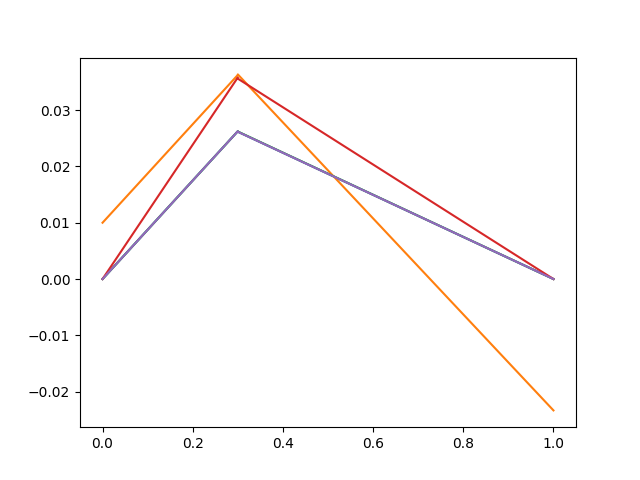

In [132]:
plt.figure()
plt.plot(zvals, xvals)
print('BPP=', div * wo)

new_wo = np.abs(z2/z1) * wo
print('New BPP=', new_div * new_wo)

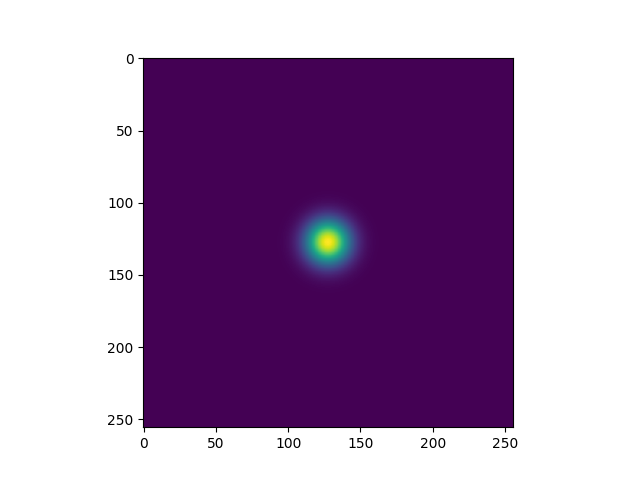

In [126]:
plt.figure()
plt.imshow(np.abs(image))

In [127]:
input_image = model.detector.get_image(rays[0])


127.67628893729773
300.4032485675314


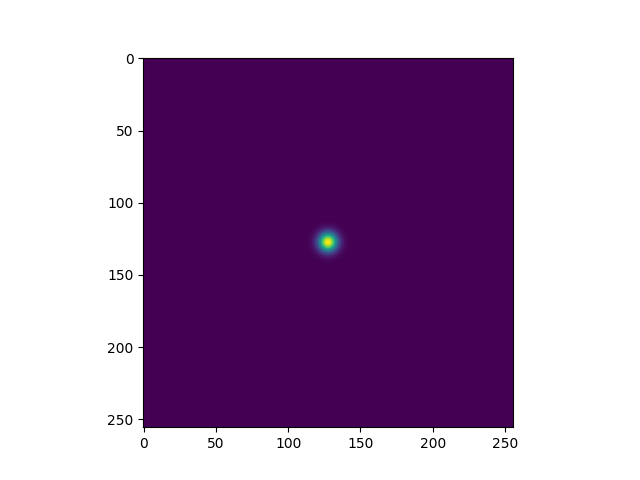

In [128]:
plt.figure()
plt.imshow(np.abs(input_image))

print(np.sum(np.abs(input_image)))
print(np.sum(np.abs(image)))

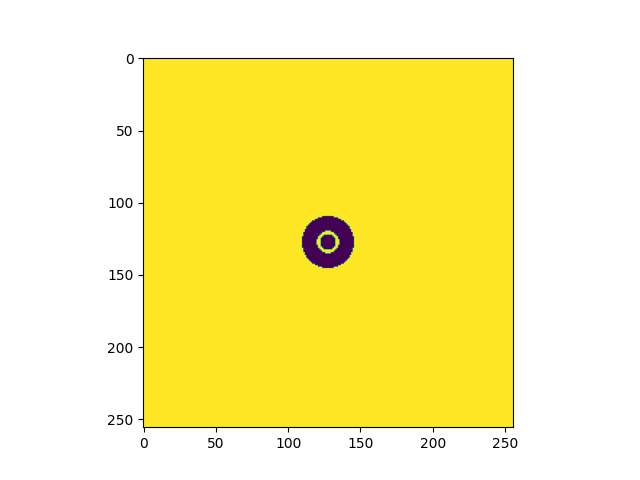

In [129]:
fig, ax1 = plt.subplots()
ax1.imshow(
    np.isclose(
        np.abs(input_image),
        np.abs(image),
        atol=0.1,
    )
)